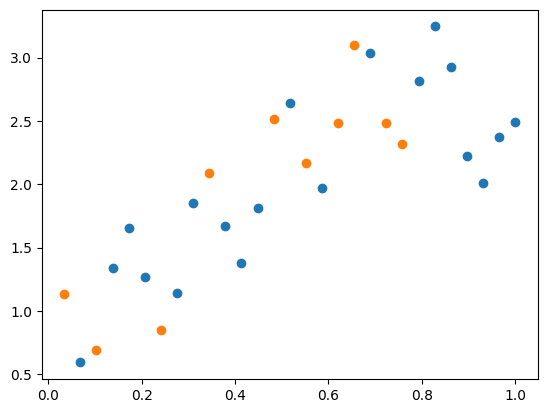

In [54]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')
#pyro.set_rng_seed(1)
torch.set_default_tensor_type(torch.DoubleTensor)

q = 2 
def func(x):
    return - np.power((np.sin(6*np.pi*x)),2) + 6*np.power(x,2) - 5*np.power(x,4) + (3/2)
x= np.linspace(0,1,100)
y = func(x)
def datafunc(x):
    return func(x) + np.random.normal(0,0.01)
def gendata(l):
    x = np.array(range(1,l))/(l-1)
    y = datafunc(x)   
    return x,y
data  = gendata(30)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[0], data[1], test_size= 10)
X, X_test, y, y_test = torch.tensor(X_train),torch.tensor(X_test),torch.tensor(y_train),torch.tensor(y_test)

plt.scatter(X, y)
plt.scatter(X_test, y_test)
plt.show()





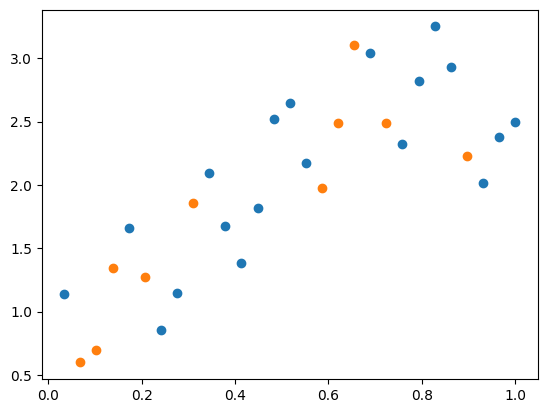

/tmp/ipykernel_18297/94269128.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)  # Exampkernelle test data
/tmp/ipykernel_18297/94269128.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(y_test)  # Example test observations


tensor(5.0084)
tensor(0.0811)


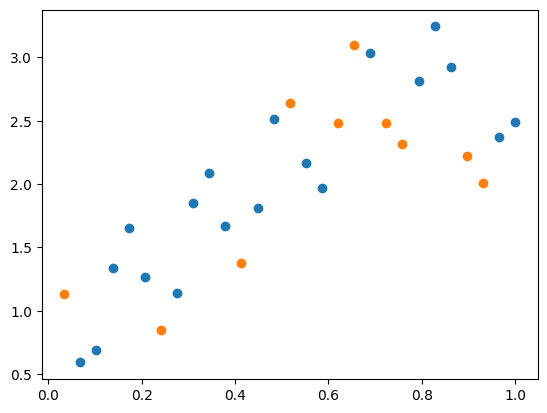

tensor(3.0106)
tensor(0.1003)


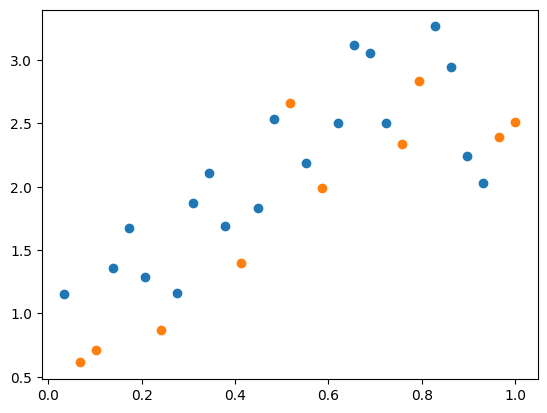

tensor(4.7545)
tensor(0.0625)


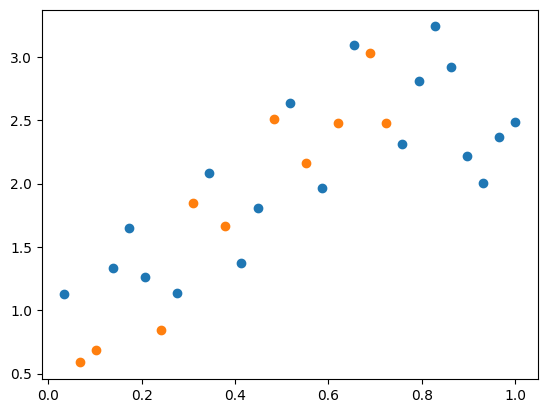

tensor(3.6494)
tensor(0.1509)


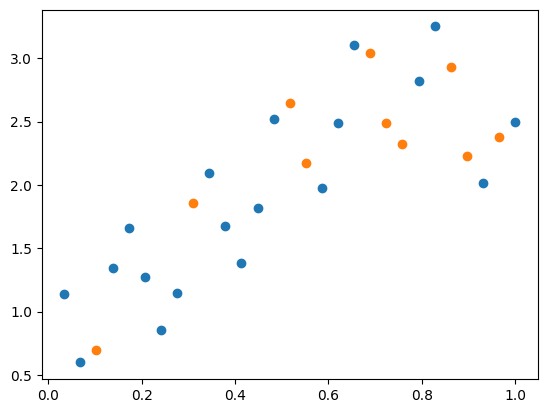

tensor(3.8718)
tensor(0.0850)


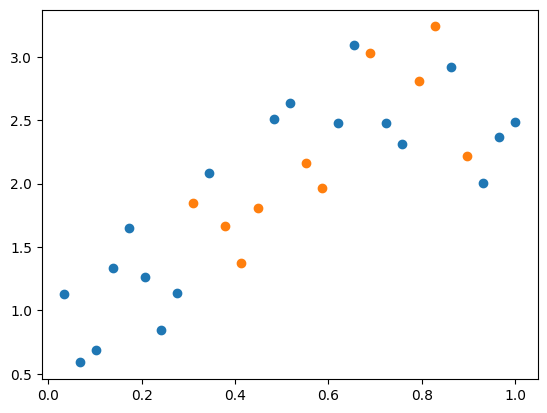

tensor(3.3535)
tensor(0.1282)


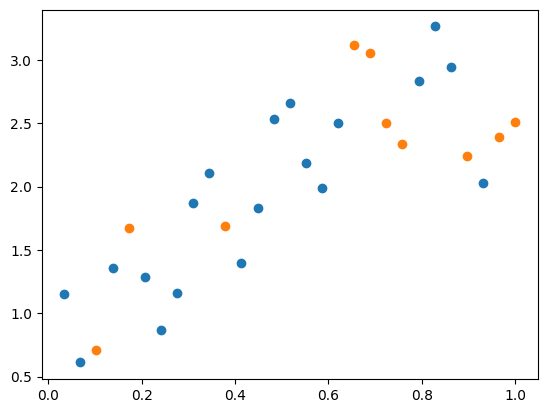

tensor(4.3329)
tensor(0.1246)


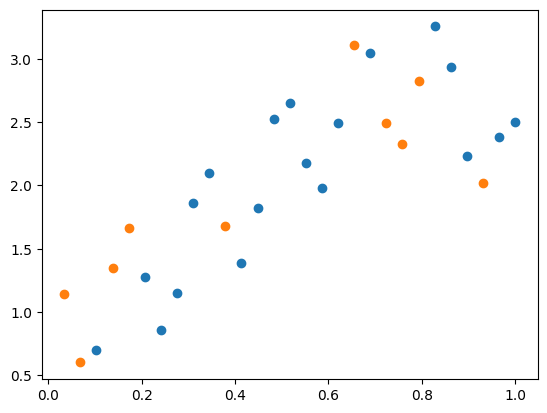

tensor(3.8156)
tensor(0.0944)


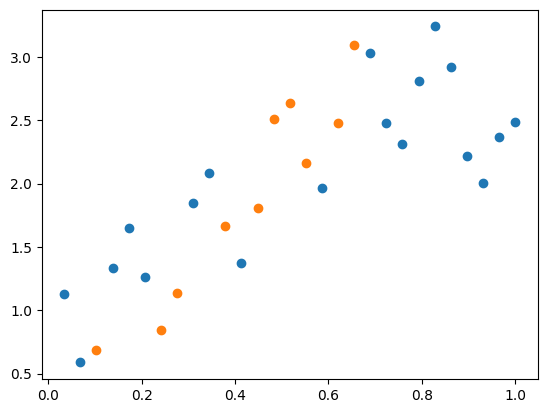

tensor(1.6870)
tensor(0.0985)


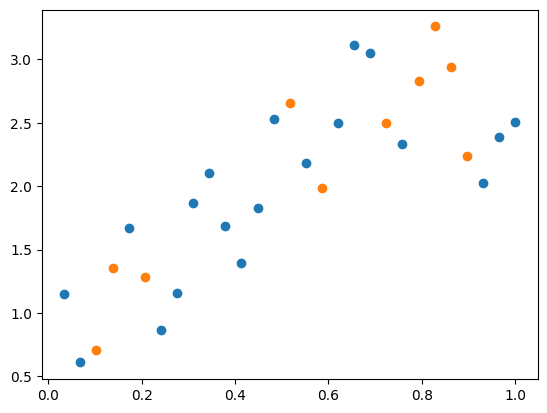

tensor(4.3958)
tensor(0.0633)


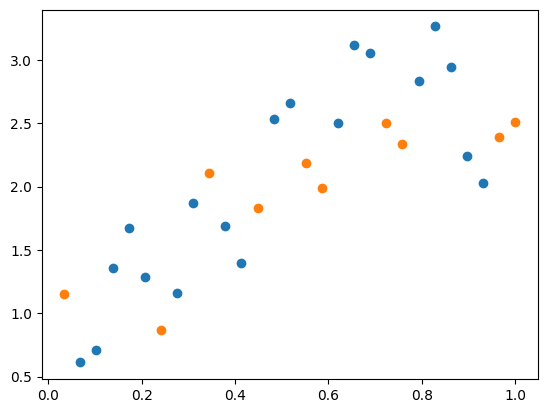

tensor(3.6715)
tensor(0.0879)


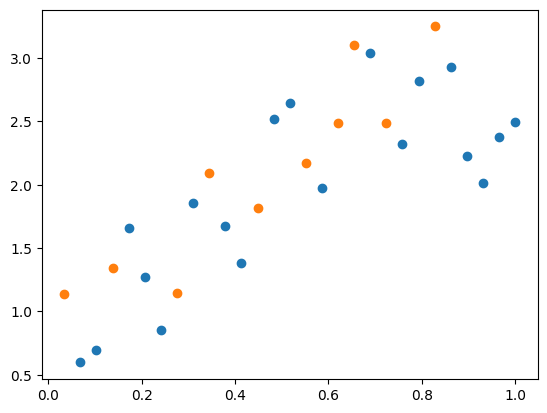

tensor(4.6589)
tensor(0.1477)


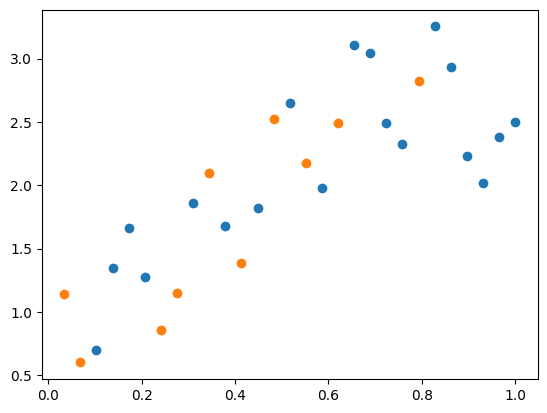

tensor(4.2300)
tensor(0.0689)


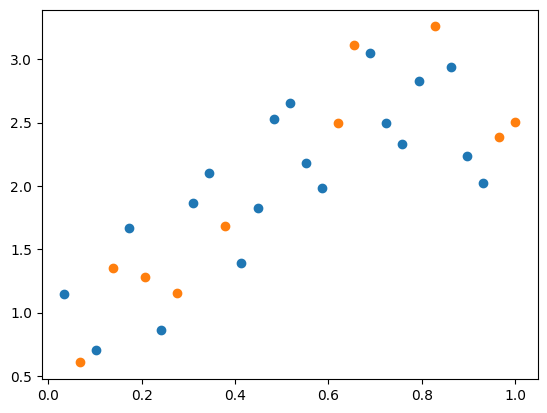

tensor(5.5172)
tensor(0.1104)


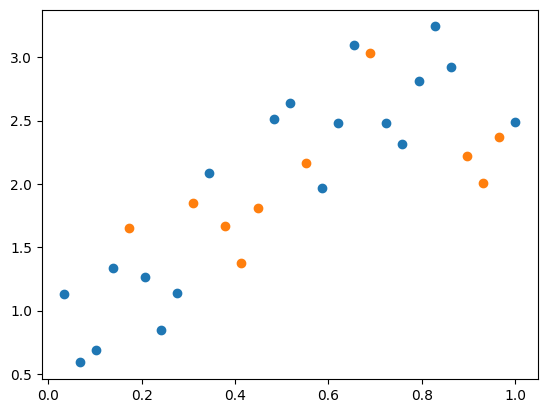

tensor(2.4803)
tensor(0.0844)


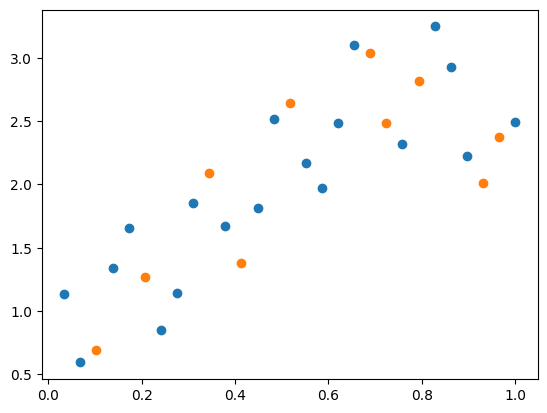

tensor(2.9885)
tensor(0.0941)


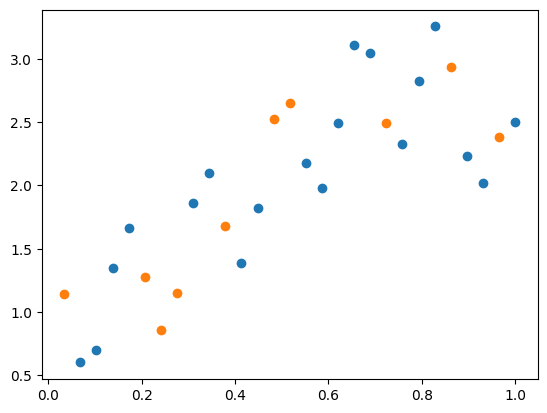

tensor(4.4556)
tensor(0.1190)


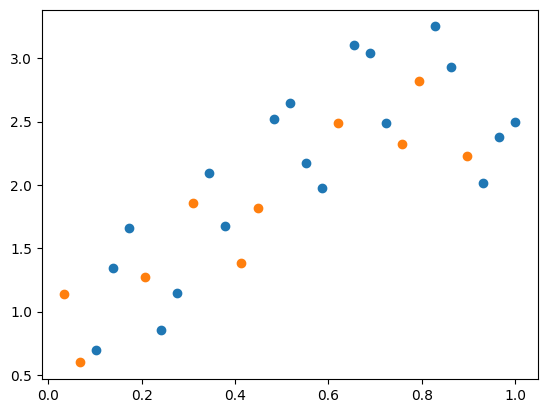

tensor(6.0772)
tensor(0.1189)


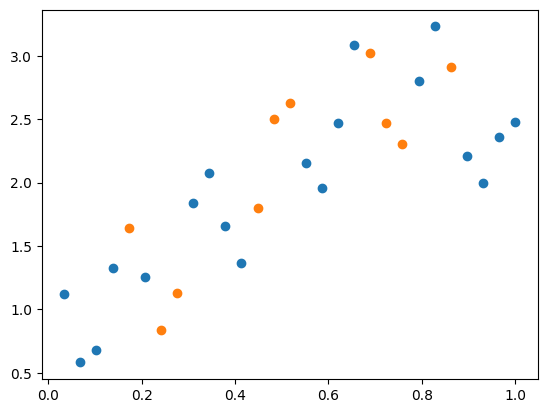

tensor(4.2608)
tensor(0.1051)


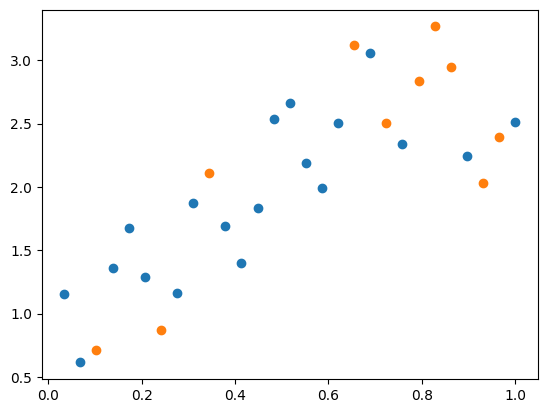

tensor(3.9767)
tensor(0.1036)


In [56]:
for i in range(20):
    smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
    assert pyro.__version__.startswith('1.9.1')
    #pyro.set_rng_seed(1)
    torch.set_default_tensor_type(torch.DoubleTensor)
    
    q = 2 
    def func(x):
        return - np.power((np.sin(6*np.pi*x)),2) + 6*np.power(x,2) - 5*np.power(x,4) + (3/2)
    x= np.linspace(0,1,100)
    y = func(x)
    def datafunc(x):
        return func(x) + np.random.normal(0,0.01)
    def gendata(l):
        x = np.array(range(1,l))/(l-1)
        y = datafunc(x)   
        return x,y
    data  = gendata(30)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(data[0], data[1], test_size= 10)
    X, X_test, y, y_test = torch.tensor(X_train),torch.tensor(X_test),torch.tensor(y_train),torch.tensor(y_test)
    
    plt.scatter(X, y)
    plt.scatter(X_test, y_test)
    plt.show()
    
    # Example usage
    X_test = torch.tensor(X_test)  # Exampkernelle test data
    Y_test = torch.tensor(y_test)  # Example test observations
    
    
    
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
    )
    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.Normal(4, 1))
    gpr.kernel.lengthscale =  pyro.nn.PyroSample(dist.Normal(0.1, 0.02))
    
    
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    variances = []
    lengthscales = []
    noises = []
    num_steps = 2000 #if not smoke_test else 2
    for i in range(num_steps):
        #include MAP estimate of kernel parameters in the loss
        
        variances.append(gpr.kernel.variance.item())
        noises.append(gpr.noise.item())
        lengthscales.append(gpr.kernel.lengthscale.item())
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    
    print(gpr.kernel.variance)
    print(gpr.kernel.lengthscale)
#posterior_samples = {"variance": torch.tensor(variances[len(variances)-1]), "lengthscale": torch.tensor(lengthscales[len(variances)-1]), "noise": torch.tensor(noises[len(variances)-1])}
#compute_posterior_likelihood(X, y, X_test, y_test, posterior_samples)

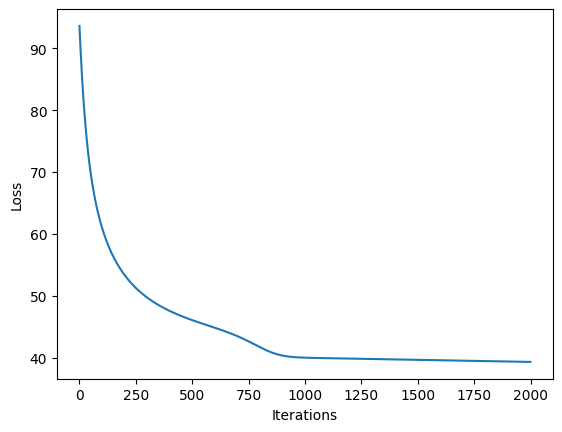

In [39]:
plot_loss(losses)

In [29]:
# Define the same model as before.
#pyro.clear_param_store()
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text
    
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.Normal(4.0, 1.))
gpr.kernel.variance = pyro.nn.PyroSample(dist.Normal(0.1, 0.1))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000 

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)


plot(model=gpr, plot_observed_data=True, plot_predictions=True)
plt.xlim((0, 1))

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).
          Trace Shapes:  
           Param Sites:  
                  noise  
          Sample Sites:  
kernel.lengthscale dist |
                  value |
   kernel.variance dist |
                  value |

In [22]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(X_test, full_cov=True)
            else:
                mean, cov = model(X_test, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)



#plot(plot_observed_data=True)  # let's plot the observed data
#_ = plt.xlim((0, 1))
#INITIAL KERNEL
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
#Gregression over the prior
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.2))
#plot(model=gpr, kernel=kernel, n_prior_samples=2)
#_ = plt.xlim((0, 1))


#Secondary KERNEL Prior
kernel2 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1)
)
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.2))
#plot(model=gpr2, kernel=kernel2, n_prior_samples=5)
#_ = plt.xlim((0, 1))


In [17]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

def kernel(X, Z, variance, lengthscale):
    calc = variance.pow(2) * torch.exp(-(1 / 2 * lengthscale.pow(2)) * (X - Z).pow(2))
    return calc

def model(X, Y):
    #PRIORS: We observe them first in the model. Then we
    variance = pyro.sample("variance", dist.LogNormal(0, 1))
    lengthscale = pyro.sample("lengthscale", dist.LogNormal(0, 1))
    noise = pyro.sample("noise", dist.Normal(0, 0.01))
    # Covariance matrix
    K = kernel(X, X, variance, lengthscale) + torch.eye(X.shape[0]) * noise.pow(2)
    print(K.shape)
    # Sample from the multivariate normal
    y = pyro.sample(
        "y", dist.MultivariateNormal(torch.zeros(X.shape[0]), covariance_matrix=K), obs=Y
    )
    return y


#X_train = torch.tensor(X)
#y_train = torch.tensor(y)
#nuts_kernel = NUTS(model)
#mcmc = MCMC(nuts_kernel, num_samples=1, warmup_steps=1)
#mcmc.run(X_train, y_train)
#mcmc.summary()
#samples = mcmc.get_samples()
#print(samples)
#print(samples)


In [23]:
import torch
import pyro.distributions as dist

def compute_likelihood(X_train, y_train, X_test, y_test, kernel, posterior_sample):
    """
    Compute the likelihood of a test set given a posterior sample.
    
    Parameters:
    - X_train: torch.Tensor, training input data
    - y_train: torch.Tensor, training target data
    - X_test: torch.Tensor, test input data
    - y_test: torch.Tensor, test target data
    - kernel: callable, kernel function
    - posterior_sample: dict, single posterior sample containing 'variance', 'lengthscale', and 'noise'
    
    Returns:
    - log_likelihood: float, the log-likelihood of the test data
    """
    # Extract parameters
    variance = posterior_sample["variance"]
    lengthscale = posterior_sample["lengthscale"]
    noise = posterior_sample["noise"]

    # Compute covariance matrices
    K_train = kernel(X_train, X_train, variance, lengthscale) + torch.eye(X_train.size(0)) * noise**2
    K_test = kernel(X_test, X_test, variance, lengthscale)
    K_train_test = kernel(X_train, X_test, variance, lengthscale)

    # Compute posterior predictive mean and covariance
    K_inv = torch.linalg.inv(K_train)
    mu_test = K_train_test.T @ K_inv @ y_train
    cov_test = K_test - K_train_test.T @ K_inv @ K_train_test

    # Compute log-likelihood
    dist_test = dist.MultivariateNormal(mu_test, covariance_matrix=cov_test)
    log_likelihood = dist_test.log_prob(y_test)

    return log_likelihood.item()

# Example usage
log_likelihood = compute_likelihood(X_train, y_train, X_test, y_test, kernel, posterior_sample)


In [19]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value}")


kernel.lengthscale_map: Parameter containing:
tensor(-1.0010, requires_grad=True)
kernel.variance_map: Parameter containing:
tensor(-0.8588, requires_grad=True)
noise: 0.010000000000000004


0.3006885904919734
-1.3533929331195773


ValueError: x and y must have same first dimension, but have shapes (500,) and (10,)

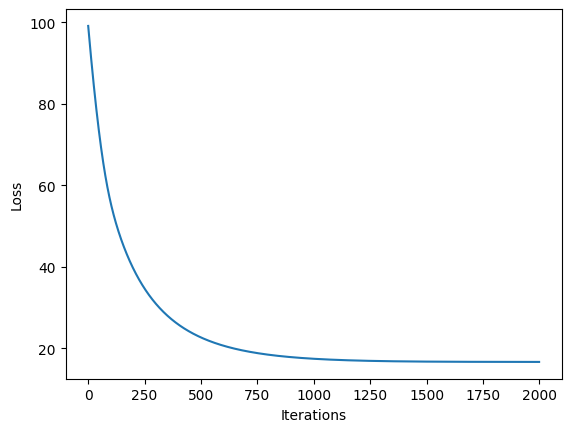

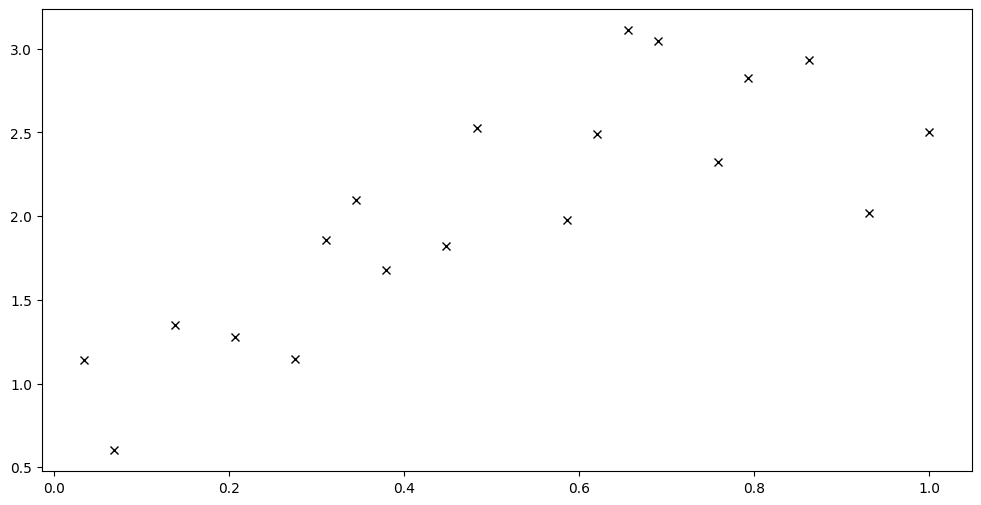

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro.distributions as dist

def plot_gp_model(X_train, y_train, samples, kernel, n_test=500):
    """
    Plot the Gaussian process model based on the averages of the MCMC samples.

    Parameters:
    X_train: torch.Tensor
        Training input data.
    y_train: torch.Tensor
        Training target data.
    samples: dict
        Posterior samples from MCMC.
    kernel: callable
        Kernel function used in the GP model.
    n_test: int
        Number of test points to plot the function.
    """
    # Extract posterior samples and convert to torch tensors
    variance_samples = torch.tensor(samples["variance"])
    lengthscale_samples = torch.tensor(samples["lengthscale"])
    noise_samples = torch.tensor(samples["noise"])

    # Test inputs for plotting
    X_test = torch.linspace(torch.min(X_train) - 1, torch.max(X_train) + 1, n_test).reshape(-1, 1)

    # Initialize arrays for predictive mean and covariance
    mean_predictions = torch.zeros(X_test.shape[0])
    cov_predictions = torch.zeros(X_test.shape[0], X_test.shape[0])

    # Compute predictive mean and covariance over all posterior samples
    for v, l, n in zip(variance_samples, lengthscale_samples, noise_samples):
        K_train_train = kernel(X_train, X_train, v, l) + torch.eye(X_train.shape[0]) * n**2
        K_train_test = kernel(X_train, X_test, v, l)
        K_test_test = kernel(X_test, X_test, v, l)

        K_inv = torch.linalg.inv(K_train_train)

        mean = K_train_test.T @ K_inv @ y_train
        cov = K_test_test - K_train_test.T @ K_inv @ K_train_test

        mean_predictions += mean
        cov_predictions += cov

    # Average predictions over posterior samples
    mean_predictions /= len(variance_samples)
    cov_predictions /= len(variance_samples)

    # Standard deviation for uncertainty
    std_predictions = torch.sqrt(torch.diag(cov_predictions))

    # Plot training data and the model
    plt.figure(figsize=(12, 6))
    plt.plot(X_train.numpy(), y_train.numpy(), "kx", label="Training Data")
    plt.plot(X_test.numpy(), mean_predictions.numpy(), "r", lw=2, label="Mean Function")
    plt.fill_between(
        X_test.numpy().flatten(),
        (mean_predictions - 2 * std_predictions).numpy(),
        (mean_predictions + 2 * std_predictions).numpy(),
        color="C0",
        alpha=0.3,
        label="95% Confidence Interval",
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gaussian Process Model")
    plt.legend()
    plt.show()

# Example usage:
# plot_gp_model(X_train, y_train, samples, kernel)






def plot_gp_predictions(X_train, y_train, X_test, samples, kernel):
    """
    Plot predictions of a Gaussian process model.

    Parameters:
    X_train: torch.Tensor
        Training input data.
    y_train: torch.Tensor
        Training target data.
    X_test: torch.Tensor
        Test input data for predictions.
    samples: dict
        Posterior samples from MCMC.
    kernel: callable
        Kernel function used in the GP model.
    """
    # Extract posterior samples
    variance_samples = samples["variance"].numpy()
    lengthscale_samples = samples["lengthscale"].numpy()
    noise_samples = samples["noise"].numpy()

    # Prepare arrays for predictions
    X_test = X_test.numpy()
    mean_predictions = np.zeros(X_test.shape[0])
    variance_predictions = np.zeros(X_test.shape[0])

    # Compute posterior predictive mean and variance
    for v, l, n in zip(variance_samples, lengthscale_samples, noise_samples):
        K_train_train = kernel(X_train, X_train, v, l) + torch.eye(X_train.shape[0]) * n**2
        K_train_test = kernel(X_train, X_test, v, l)
        K_test_test = kernel(X_test, X_test, v, l)

        K_inv = torch.linalg.inv(K_train_train)

        # Posterior predictive mean and covariance
        mu_post = K_train_test.T @ K_inv @ y_train
        cov_post = K_test_test - K_train_test.T @ K_inv @ K_train_test

        mean_predictions += mu_post.numpy()
        variance_predictions += torch.diag(cov_post).numpy()

    # Average over posterior samples
    mean_predictions /= len(variance_samples)
    variance_predictions /= len(variance_samples)

    # Plot training data, predictive mean, and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(X_train.numpy(), y_train.numpy(), "bo", label="Training Data")
    plt.plot(X_test, mean_predictions, "r", label="Predictive Mean")
    plt.fill_between(
        X_test.ravel(),
        mean_predictions - 2 * np.sqrt(variance_predictions),
        mean_predictions + 2 * np.sqrt(variance_predictions),
        color="orange",
        alpha=0.3,
        label="95% Confidence Interval",
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gaussian Process Predictions")
    plt.legend()
    plt.show()

# Example usage:
# Define test points
# X_test = torch.linspace(-5, 5, 100).reshape(-1, 1)
# plot_gp_predictions(X_train, y_train, X_test, samples, kernel)
